<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import gensim
from keras.optimizers import Adam
from keras_preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounting google drive to access data and save models

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Challenge2'
/content/drive/My Drive/Challenge2


Reading data 

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')


Removing useless columns

In [5]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

Removing Stopwords and other characters using RegEx

In [6]:
STOPWORDS = set(stopwords.words('french'))

def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [7]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

In [8]:
x_train = df_train["data"]
y_train = df_train["label"]

x_test = df_test["data"]
y_test = df_test["label"]

Text vectorization using Keras

In [9]:
max_features = 10000
maxlen = 512

In [10]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [11]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

Embedding Matrix for our model

In [12]:
#!wget https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin

In [13]:
word2vec_model_fr = gensim.models.KeyedVectors.load_word2vec_format("frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin",binary=True)

In [14]:
embeddings_index = dict((key,word2vec_model_fr[key]) for key in word2vec_model_fr.vocab.keys())

In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Parameters of the Deep learning model

In [16]:
batch_size = 256
epochs = 20
embed_size = 200

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

Model architecture

In [17]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer 
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 512, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,219,969
Trainable params: 219,969
Non-trainable params: 2,000,000
_________________________________________________________________


model.fit()

In [19]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/20
6/6 [==============================] - 32s 4s/step - loss: 0.5983 - accuracy: 0.6776 - val_loss: 0.4771 - val_accuracy: 0.8086 - lr: 0.0100
Epoch 2/20
6/6 [==============================] - 27s 5s/step - loss: 0.5582 - accuracy: 0.7202 - val_loss: 0.6703 - val_accuracy: 0.5597 - lr: 0.0100
Epoch 3/20
6/6 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5604
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
6/6 [==============================] - 25s 4s/step - loss: 0.6946 - accuracy: 0.5604 - val_loss: 0.6749 - val_accuracy: 0.5597 - lr: 0.0100
Epoch 4/20
6/6 [==============================] - 26s 4s/step - loss: 0.6759 - accuracy: 0.5604 - val_loss: 0.6715 - val_accuracy: 0.5597 - lr: 0.0050
Epoch 5/20
6/6 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.5597
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
6/6 [==============================] - 25s 4s/step - loss: 0.6671 - accu

Accuracy test after training

In [20]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

46/46 [==============================] - 12s 252ms/step - loss: 0.1212 - accuracy: 0.9712
Accuracy of the model on Training Data is -  97.11934328079224 %
16/16 [==============================] - 4s 250ms/step - loss: 0.1645 - accuracy: 0.9444
Accuracy of the model on Testing Data is -  94.44444179534912 %


Saving model to google drive for further use

In [21]:
path_to_save = '/content/drive/MyDrive/Challenge2/model6'

In [22]:
model.save(path_to_save)

Graphic of model training


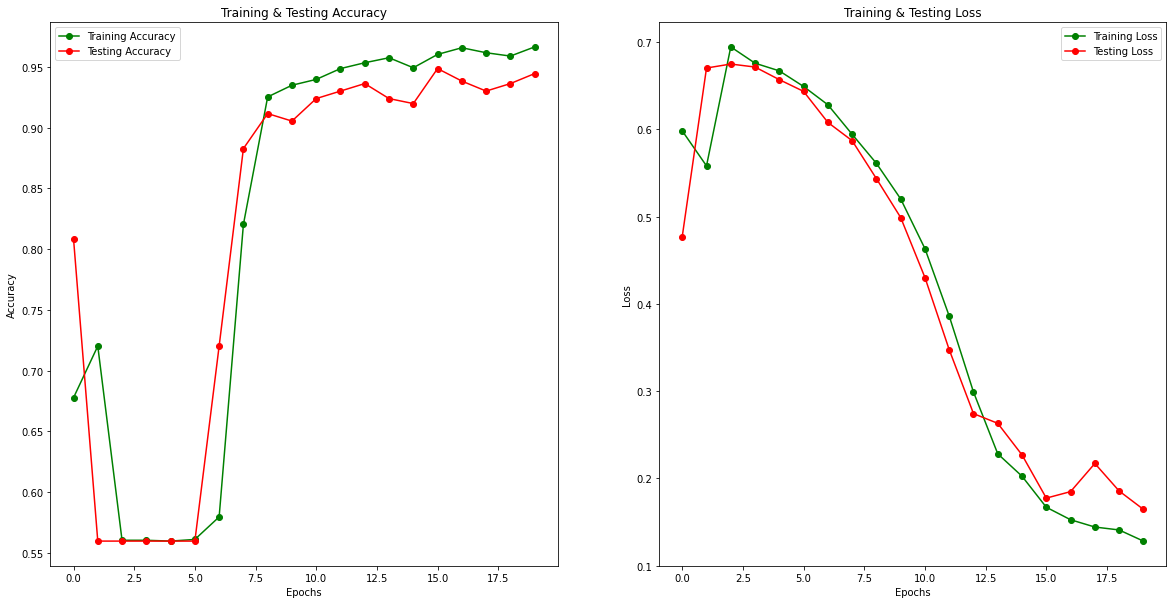

In [23]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Prediction on some data

In [24]:
pred = model.predict(X_test)

16/16 [==============================] - 4s 250ms/step


Confusion matrix

In [25]:
print(classification_report(list(y_test), np.round(pred).astype(int), target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.97      0.93      0.95       272
        Fake       0.92      0.96      0.94       214

    accuracy                           0.94       486
   macro avg       0.94      0.95      0.94       486
weighted avg       0.95      0.94      0.94       486



In [26]:
cm = confusion_matrix(y_test,np.round(pred).astype(int))
cm

array([[253,  19],
       [  8, 206]])

In [27]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

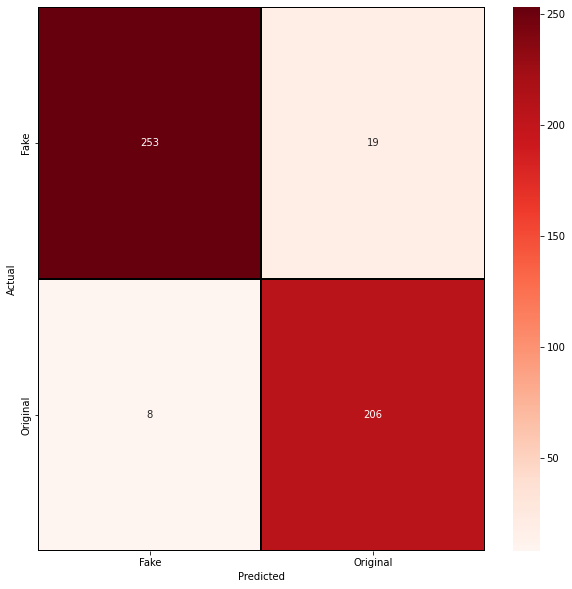

In [28]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [29]:
from tensorflow import keras
model22 = keras.models.load_model(path_to_save)

In [30]:
print("Accuracy of the model on Testing Data is - " , model22.evaluate(X_test,y_test)[1]*100 , "%")

16/16 [==============================] - 5s 262ms/step - loss: 0.1645 - accuracy: 0.9444
Accuracy of the model on Testing Data is -  94.44444179534912 %
